
<b>INSTITUTO FEDERAL DE GOIÁS<br/>
PÓS-GRADUAÇÃO EM INTELIGÊNCIA ARTIFICIAL APLICADA<br/></b>
Disciplina: Processamento de Linguagem Natural  <br/>
Professor: Daniel Xavier de Sousa <br/>
Alunos: Wagner Silva, Cleibson, Marcos Rodrigues


---

In [2]:
# Importação das bibliotecas
import pandas as pd

import numpy as np

from tqdm import tqdm

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, roc_curve, auc, accuracy_score, confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import seaborn as sbn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#GLOVE_PATH = '/content/drive/MyDrive/Colab_Notebooks/projeto_nlp_notebooks/embeddings/glove.6B.50d.txt'
#DATASET_PATH = '/content/drive/MyDrive/Colab_Notebooks/projeto_nlp_notebooks/datasets/buscape_preprocessed.csv'
GLOVE_PATH = '../embeddings/glove.6B.50d.txt'
DATASET_PATH = '../datasets/buscape_preprocessed.csv'

In [4]:
# Carregando 50-dimensional GloVe embeddings
glove_file = GLOVE_PATH
glove_embeddings = {}
with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        embedding = np.array(values[1:], dtype='float32')

        # Tratando a substituição da vírgula por ponto no vetor de embedding
        if ',' in values[1]:
            embedding = [float(val.replace(',', '.')) for val in values[1:]]

        glove_embeddings[word] = embedding

In [5]:
embedding_dim = len(next(iter(glove_embeddings.values())))

print('Achados %s vetores de palavras' % len(glove_embeddings))
print(f'Vetores de {embedding_dim} dimensões')

Achados 400000 vetores de palavras
Vetores de 50 dimensões


In [6]:
# Carregando dataset pre-processado
df = pd.read_csv(DATASET_PATH)

In [7]:
df.shape

(133632, 2)

In [8]:
df.head(2)

,review_text,rating
0,estou muito satisfeito o visor e melhor do que...,1
1,muito boa o que gostei preco o que nao gostei ...,1


In [9]:
#reviews_batch_01, reviews_batch_02, labels_batch_01, labels_batch_02 = train_test_split(df['review_text'], df['rating'], test_size=0.5, random_state=42)

In [10]:
#print(reviews_batch_01.shape[0])
#print(reviews_batch_02.shape[0])

In [9]:
print(df['rating'].value_counts())

rating
1    66816
0    66816
Name: count, dtype: int64


In [10]:
documents = df['review_text']
labels = np.array(df['rating'])

In [103]:
#documents = ['bom', 'ruim','bom', 'ruim','bom', 'ruim','bom', 'ruim','bom', 'ruim',]
#labels = np.array([1,0,1,0,1,0,1,0,1,0,])

In [103]:
# Tokenização e embedding dos documentos
max_sequence_length = 20  # Número máximo de palavras por documento
embedded_documents = []
for doc in tqdm((documents),desc="Processing"):
    words = str(doc).lower().split()
    embedded_doc = [glove_embeddings.get(word, np.zeros(embedding_dim)) for word in words]
    if len(embedded_doc) < max_sequence_length:
        embedded_doc.extend([np.zeros(embedding_dim)] * (max_sequence_length - len(embedded_doc)))
    else:
        embedded_doc = embedded_doc[:max_sequence_length]
    embedded_documents.append(embedded_doc)

embedded_documents = np.array(embedded_documents)

Processing: 100%|██████████| 133632/133632 [00:05<00:00, 24703.60it/s]


In [104]:
DROPOUT = 0.05
LEARNING_RATE = 5e-4
EPOCHS = 5
FOLDS = 10
LOSS = 'binary_crossentropy'
OPTIMIZER = Adam(learning_rate=LEARNING_RATE)
METRICS = ['accuracy']
BATCH_SIZE = 32
EARLY_STOP = EarlyStopping('val_loss', patience=5)
CALLBACKS = [EARLY_STOP]
VERBOSE=0

In [105]:
# Arquitetura de rede neural MLP
model = Sequential()
model.add(Dense(24, activation="relu", input_shape=(max_sequence_length, embedding_dim)))
model.add(Flatten())
model.add(Dropout(DROPOUT))
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 20, 24)            1224      
                                                                 
 flatten_7 (Flatten)         (None, 480)               0         
                                                                 
 dropout_7 (Dropout)         (None, 480)               0         
                                                                 
 dense_15 (Dense)            (None, 1)                 481       
                                                                 
Total params: 1,705
Trainable params: 1,705
Non-trainable params: 0
_________________________________________________________________


In [106]:
# k-fold cross-validation
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

In [107]:
# Compilando o modelo
model.compile(
    loss=LOSS,
    optimizer=OPTIMIZER,
    metrics=METRICS
)

In [108]:
# Treinamento do modelo
train_loss_history = []
train_accuracy_history = []
train_f1_scs = []

val_loss_history = []
val_accuracy_history = []
val_f1_scs = []

val_tprs = []
val_aucs = []
val_mean_fpr = np.linspace(0, 1, 100)

for fold, (train_idx, test_idx) in tqdm((enumerate(skf.split(embedded_documents, labels), start=1)), desc='Processing'):
    print(f'fold = {fold} de {FOLDS}')

    X_train, X_test = embedded_documents[train_idx], embedded_documents[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]

    model_history = model.fit(
        X_train,
        y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=VERBOSE,
        validation_data=(X_test, y_test),
        callbacks=CALLBACKS
    )

    # train pred
    train_pred = (model.predict(X_train) > 0.5).astype(int)

    # train loss
    train_loss_history.append(model_history.history['loss'])

    # train acc
    train_accuracy_history.append(model_history.history['accuracy'])

    # train f1
    train_fold_f1 = f1_score(y_train, train_pred)
    train_f1_scs.append(train_fold_f1)

    # -------------------------------------------------------------------

    # val pred
    val_pred = (model.predict(X_test) > 0.5).astype(int)

    # val loss
    val_loss_history.append(model_history.history['val_loss'])

    # val acc
    val_accuracy_history.append(model_history.history['val_accuracy'])

    # val f1
    val_fold_f1 = f1_score(y_test, val_pred)
    val_f1_scs.append(val_fold_f1)

    # train roc curve auc
    fpr, tpr, thresholds = roc_curve(y_test, val_pred)
    roc_auc = auc(fpr, tpr)
    val_tprs.append(np.interp(val_mean_fpr, fpr, tpr))
    val_aucs.append(roc_auc)

print('Finished!')

Processing: 0it [00:00, ?it/s]

fold = 1 de 10
418/418 [==============================] - 0s 1ms/step


Processing: 1it [00:42, 42.18s/it]

fold = 2 de 10
418/418 [==============================] - 1s 1ms/step


Processing: 2it [01:28, 44.68s/it]

fold = 3 de 10
418/418 [==============================] - 0s 946us/step


Processing: 3it [02:14, 45.24s/it]

fold = 4 de 10
418/418 [==============================] - 0s 921us/step


Processing: 4it [02:55, 43.49s/it]

fold = 5 de 10
418/418 [==============================] - 0s 1ms/step


Processing: 5it [03:38, 43.48s/it]

fold = 6 de 10
418/418 [==============================] - 0s 904us/step


Processing: 6it [04:21, 43.10s/it]

fold = 7 de 10
418/418 [==============================] - 0s 916us/step


Processing: 7it [05:03, 42.81s/it]

fold = 8 de 10
418/418 [==============================] - 0s 1ms/step


Processing: 8it [05:52, 44.79s/it]

fold = 9 de 10
418/418 [==============================] - 1s 1ms/step


Processing: 9it [06:35, 44.35s/it]

fold = 10 de 10
418/418 [==============================] - 0s 1ms/step


Processing: 10it [07:23, 44.36s/it]

Finished!


In [109]:
avg_train_loss = np.mean(train_loss_history)
avg_train_acc = np.mean(train_accuracy_history)
avg_train_f1 = np.mean(train_f1_scs)

avg_val_loss = np.mean(val_loss_history)
avg_val_acc = np.mean(val_accuracy_history)
avg_val_f1 = np.mean(val_f1_scs)

print(f"Mean train loss: {avg_train_loss}")
print(f"Mean train acc: {avg_train_acc}")
print(f"Mean train f1: {avg_train_f1}")
print('-'*80)
print(f"Mean val loss: {avg_val_loss}")
print(f"Mean val acc: {avg_val_acc}")
print(f"Mean val f1: {avg_val_f1}")

Mean train loss: 0.4567506676912308
Mean train acc: 0.7868863344192505
Mean train f1: 0.8002599413869756
--------------------------------------------------------------------------------
Mean val loss: 0.4490340512990951
Mean val acc: 0.7926367568969727
Mean val f1: 0.7952576830445065


In [110]:
#graph_path = '/content/drive/MyDrive/Colab_Notebooks/projeto_nlp_notebooks/graphs/gloVe-mlp/'
graph_path = './graphs/02_gloVe_mlp/'

In [111]:
def plot_eval_metrics(model, metric):
    plt.plot(model.history[metric])
    plt.plot(model.history[f'val_{metric}'])
    plt.title(f'model {metric}')
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(f'{graph_path}train_test_{metric}.png')
    plt.show()

def plot_train_folds(history, metric):
    plt.figure(figsize=(10, 6))
    for fold_num, fold_loss in enumerate(history):
        plt.plot(fold_loss, label=f'Fold {fold_num+1}')
    plt.xlabel('Epoch')
    plt.ylabel(f'Training {metric}')
    plt.title(f'Training {metric} per Epoch for Each Fold')
    plt.legend()
    plt.savefig(f'{graph_path}train_folds_{metric}.png')
    plt.show()

def plot_roc_auc_curve(desc, mean_tpr, mean_auc):
    plt.figure()
    plt.plot(val_mean_fpr, mean_tpr, color='b', label=f'{desc} Mean ROC curve (AUC = {mean_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{desc} Mean Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig(f'{graph_path}train_roc_auc_curve_{desc}.png')
    plt.show()

def plot_confunsion_matrix(cm):
    plt.figure(figsize=(6,4))
    sbn.heatmap(cm, annot=True, linewidth=0.2, annot_kws={'size':12}, fmt='.0f')
    plt.title("Matriz de Confusão", fontsize=12)
    plt.xlabel('Real')
    plt.ylabel('Predito')
    plt.savefig(f'{graph_path}test_conf_matrix.png')
    plt.show()

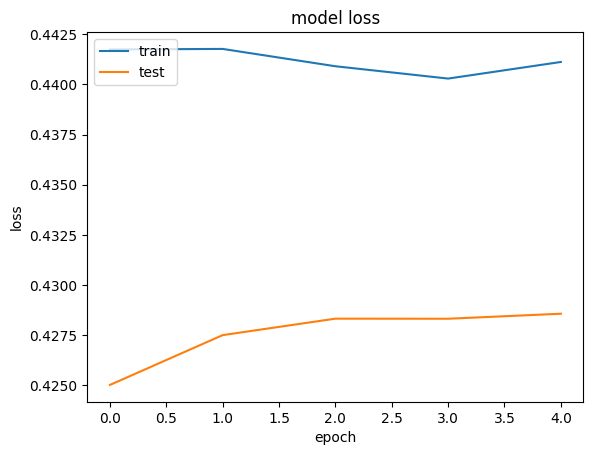

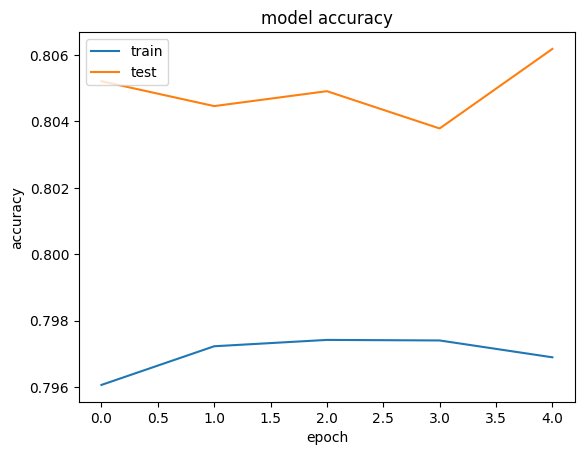

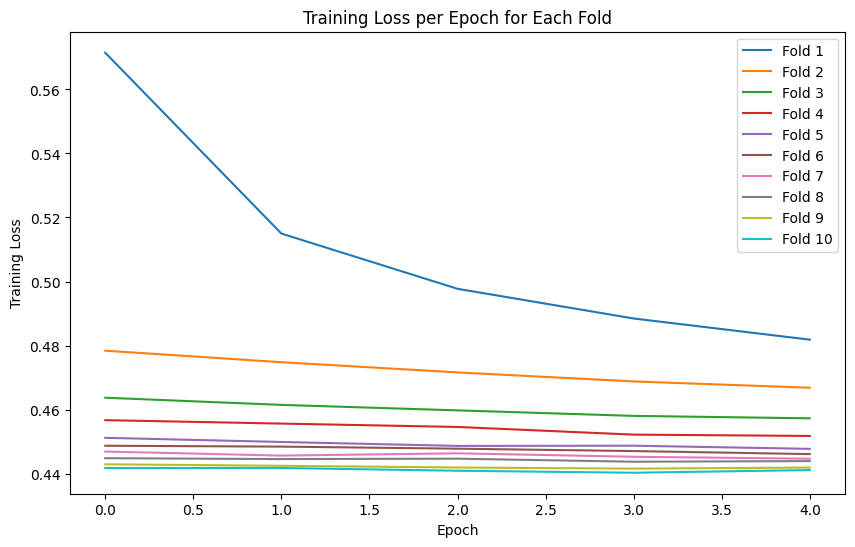

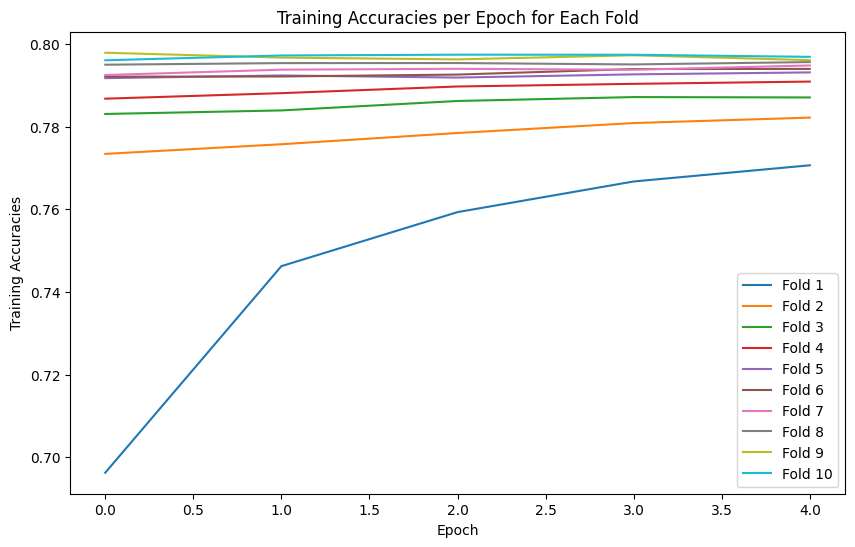

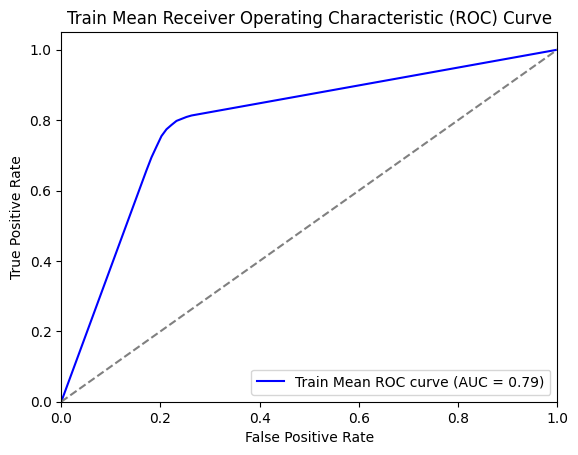

In [112]:
plot_eval_metrics(model_history, 'loss')
plot_eval_metrics(model_history, 'accuracy')

plot_train_folds(train_loss_history, 'Loss')
plot_train_folds(train_accuracy_history, 'Accuracies')

mean_tpr = np.mean(val_tprs, axis=0)
mean_auc = auc(val_mean_fpr, mean_tpr)
plot_roc_auc_curve('Train', mean_tpr, mean_auc)

In [113]:
predict = np.round(model.predict(X_test))

418/418 [==============================] - 1s 1ms/step


In [114]:
accuracy = accuracy_score(y_test, predict)
accuracy

0.8061812467260345

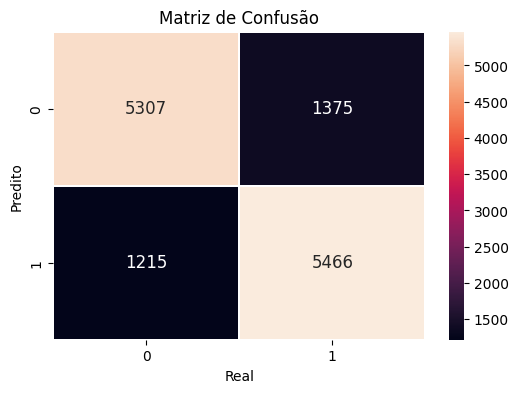

In [115]:
cm = confusion_matrix(y_test, predict)
plot_confunsion_matrix(cm)